In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from ipywidgets import interact, FloatSlider, fixed

from src.final_task.task1 import compute_figure_e_data
from src.final_task.task2 import global_stiffness_matrix, is_on_line_segment, calculate_maximum_force, calculate_nodal_forces_from_distributed_force, apply_fixed_boundary_conditions, zone_1_line, zone_2_line, E, nu, angle, sigma_T, calculate_stress

In [2]:
def plot_deformation(nodes, triangles, displacements, scale):
    """
    Plots the deformed part with a color map of principal stresses.
    """
    displacements_scaled = displacements * scale
    updated_nodes = np.array(nodes) + displacements_scaled.reshape(-1, 2)
    triang = tri.Triangulation(updated_nodes[:, 0], updated_nodes[:, 1], triangles)
    stresses = calculate_stress(nodes, triangles, displacements, E, nu)
    stress_magnitudes = np.array([np.linalg.norm(stress) for stress in stresses])
    plt.figure(figsize=(8, 6))
    plt.tripcolor(triang, facecolors=stress_magnitudes, edgecolors='k', cmap='jet')
    plt.colorbar(label='Principal Stress')
    plt.title('Deformed Part with Stress Color Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    plt.show()

In [3]:
def draw_figure(nodes, triangles, fixed_nodes, force_nodes, title):
    plt.figure(figsize=(10, 10))
    plt.triplot([node[0] for node in nodes], [node[1] for node in nodes], triangles, 'b-')
    plt.scatter([node[0] for node in nodes], [node[1] for node in nodes], color='red', s=5)
    plt.scatter([nodes[node][0] for node in fixed_nodes], [nodes[node][1] for node in fixed_nodes], color='blue', s=100)
    plt.scatter([nodes[node][0] for node in force_nodes], [nodes[node][1] for node in force_nodes], color='pink', s=100)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

In [4]:
nodes, triangles = compute_figure_e_data()
K_global = global_stiffness_matrix(nodes, triangles, E, nu)
fixed_nodes = [i for i, node in enumerate(nodes)
               if is_on_line_segment(node, zone_1_line[0], zone_1_line[1])]
force_nodes = [i for i, node in enumerate(nodes)
              if is_on_line_segment(node, zone_2_line[0], zone_2_line[1])]

K_global_modified = apply_fixed_boundary_conditions(K_global, fixed_nodes)
P_max = calculate_maximum_force(K_global_modified, nodes, force_nodes, triangles, E, nu, sigma_T)

F = calculate_nodal_forces_from_distributed_force(nodes, force_nodes, P_max, angle)
displacements = np.linalg.solve(K_global_modified, F)
print(F)
# Interactive plot
interact(plot_deformation, nodes=fixed(nodes), triangles=fixed(triangles),
         displacements=fixed(displacements), scale=FloatSlider(min=0, max=1, step=0.01, value=0.1))

[-3.05       -5.28275496 -3.05       ...  0.          0.
  0.        ]


interactive(children=(FloatSlider(value=0.1, description='scale', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_deformation(nodes, triangles, displacements, scale)>

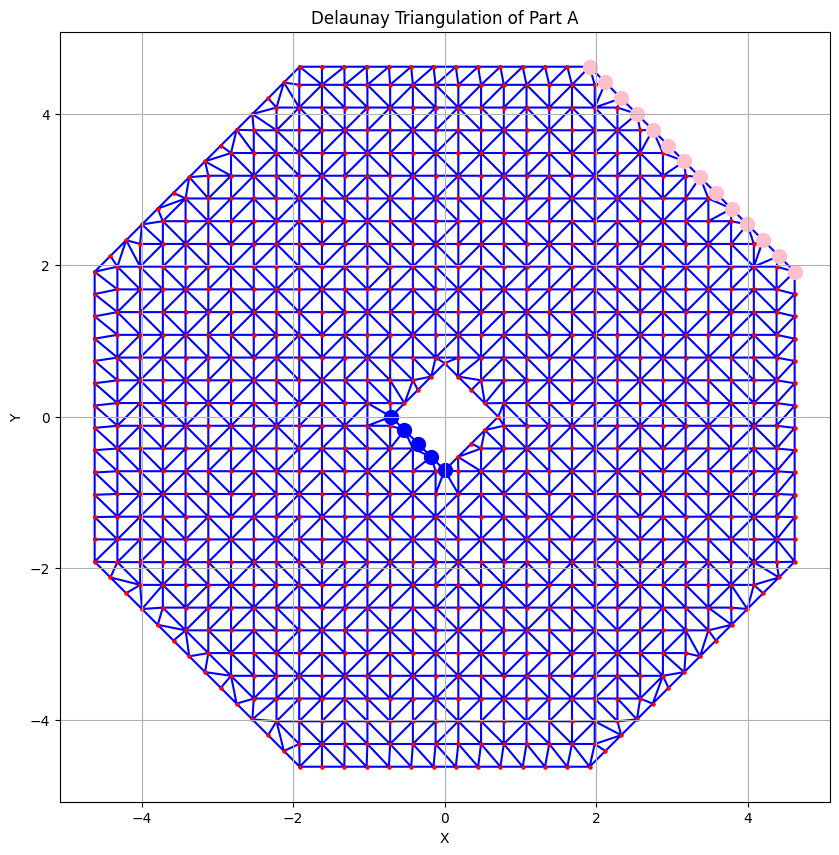

In [5]:
draw_figure(nodes, triangles, fixed_nodes, force_nodes, 'Delaunay Triangulation of Part A')

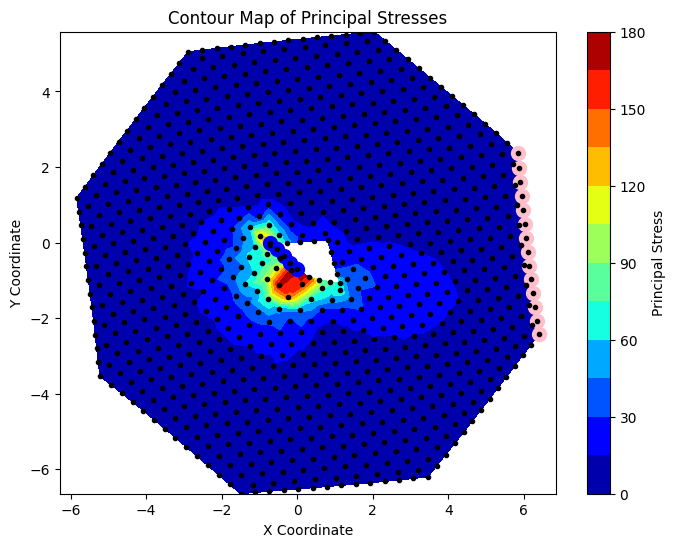

In [6]:
def principal_stress(stress):
    """
    Calculate the principal stress from the stress tensor.
    """
    sigma_x, sigma_y, tau_xy = stress
    principal = np.sqrt(((sigma_x - sigma_y) / 2) ** 2 + tau_xy ** 2)
    return principal

def principal_stress_at_nodes(nodes, triangles, stresses):
    """
    Calculate the principal stress at each node.
    """
    principal_stresses = np.zeros(len(nodes))
    for i, tri in enumerate(triangles):
        for node_index in tri:
            principal = principal_stress(stresses[i])
            principal_stresses[node_index] = max(principal_stresses[node_index], principal)
    return principal_stresses

def principal_stress_at_nodes(nodes, triangles, stresses):
    """
    Calculate the principal stress at each node.
    """
    principal_stresses = np.zeros(len(nodes))
    for i, tri in enumerate(triangles):
        for node_index in tri:
            principal = principal_stress(stresses[i])
            principal_stresses[node_index] = max(principal_stresses[node_index], principal)
    return principal_stresses

def plot_principal_stress_contour(nodes, triangles, displacements, scale):
    """
    Plots a contour map of principal stresses.
    """
    displacements_scaled = displacements * scale
    updated_nodes = np.array(nodes) + displacements_scaled.reshape(-1, 2)
    triangle_stresses = calculate_stress(nodes, triangles, displacements, E, nu)
    principal_stresses = principal_stress_at_nodes(nodes, triangles, triangle_stresses)
    triang = tri.Triangulation(updated_nodes[:, 0], updated_nodes[:, 1], triangles)
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang, principal_stresses, levels=14, cmap='jet')
    plt.colorbar(label='Principal Stress')
    plt.plot(updated_nodes[:, 0], updated_nodes[:, 1], 'ko', markersize=3)
    plt.scatter([updated_nodes[node][0] for node in force_nodes], [updated_nodes[node][1] for node in force_nodes], color='pink', s=100)
    plt.scatter([updated_nodes[node][0] for node in fixed_nodes], [updated_nodes[node][1] for node in fixed_nodes], color='blue', s=100)
    plt.title('Contour Map of Principal Stresses')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')


def annotate_nodes(nodes, principal_stresses, fixed_nodes, force_nodes):
    """
    Annotate the nodes with boundary conditions and nodes with extreme stress values.
    """
    for node in fixed_nodes + force_nodes:
        plt.annotate(f'{principal_stresses[node]:.2f}', (nodes[node][0], nodes[node][1]),
                     textcoords="offset points", xytext=(5,-5), ha='center')

    max_stress_node = np.argmax(principal_stresses)
    min_stress_node = np.argmin(principal_stresses)
    plt.annotate(f'Max: {principal_stresses[max_stress_node]:.2f}', (nodes[max_stress_node][0], nodes[max_stress_node][1]),
                 textcoords="offset points", xytext=(5,-5), ha='center')
    plt.annotate(f'Min: {principal_stresses[min_stress_node]:.2f}', (nodes[min_stress_node][0], nodes[min_stress_node][1]),
                 textcoords="offset points", xytext=(5,-5), ha='center')


plot_principal_stress_contour(nodes, triangles, displacements, 0.5)
